This Python Notebook is created for the purposes of an AI Tutorial to be conducted in Argonne National Laboratory, and is co-authored by Arun Mannodi-Kanakkithodi, Olle Heinonen, Venkatram Vishwanath and Logan Ward. The work discussed here is based on the following publication by Arun Mannodi-Kanakkithodi et al.: https://www.nature.com/articles/s41524-020-0296-7

In this tutorial, we will work through a problem that follows a fairly standard workflow in a science application of AI. The problem is to make predictions based on learning from data sets. In this case, the prediction we want to make is whether or not hypothetical atomic defects or impurities in semiconductors are suitable for solar cell applications; specifically, we want to make predictions of the charge and Fermi level dependent defect formation energy for specific defects in some semiconductors for which there exist no data, based on calculations on some set of defects and semiconductors. The raw data in this case comes from density functional theory calculations. The semiconductor chemical space studied here is Cd-based chalcogenides with the general formula CdX, where the anion X can be Te, Se or S. The chemical space of defect or impurity atoms is obtained by sweeping across periods II to VI of the periodic table.

What we desire ultimately for any defect/impurity in a given semiconductor compound is a full charge-dependent formation energy vs Fermi level (as it goes from the valence band minimum to the conduction band maximum) plot, an example of which is shown in Slide 2 of the attached presentation. Predicting two types of properties enables the creation of such plots: the neutral state formation energy, and every relevant q1/q2 defect charge transition level (the Fermi level at which the defect transitions from one charge state, q1, to another, q2). We will thus be training ML predictive models for both properties. This particular notebook pertains to the workflow leading to the prediction of neutral state formation energies, calculated at three types of chemical potential conditions: Cd-rich, moderate, and anion-rich (where anion is Te, Se or S).

We have to process the raw data to extract relevant quantities for defects in semiconductors. Then we have to construct descriptors X based on the data, and also the properties P that we think are the important ones. The goal is to obtain a model that can map the descriptors X onto properties P with some desired accuracy. The descriptors are not necessarily obvious so we have to spend some time to examine what are relevant descriptors, as well as what are not so relevant descriptors or redundant descriptors. Next, we will select a suitable machine learning model. In this case, we will mostly focus on Random Forest, which is a regression model, but we may also look at other regression models, such as Kernel Ridge Regression or Least Absolute Shrinkage and Selection Operator (LASSO). Of course, neural network may also be used. We will train our regression model on subsets of the available data (training data) and use other subsets for validation (test data). The training will involve "tweaking" hyperparameters (parameters inside the specific models) to optimize the model. Finally, we will then test the model by making predictions for systems outside the training set - we have some calculated data points outside the training sets that we will use for comparison to see how well the model did.

*NOTE: We use the terms defect and impurity interchangeably here; any atom (whether native or external) that breaks the stoichiometry of a compound by occuring at an interstitial site or substituting an atom at a different site, or simply missing from its original site (vacancy), is referred to in general as a point defect. The emphasis on 'impurity' is to drive home the distinction of an external atom being present as a defect, as opposed to a native defect.

The workflow will all be done using python in Jupyter notebook. The regression models we use will be imported from the scikit-learn library (https://scikit-learn.org). There are other libraries that could be used, e.g. pytorch (https://pytorch.org/) or keras (https://keras.io/).

First, we will import standard python libraries.

In [44]:
from __future__ import print_function
import numpy as np    
import csv
import copy
import random
import pandas
import matplotlib.pyplot as plt


Next, we will import various regression models, including Random Forest, LASSO, Kernel Ridge, as well as some regression utilities from scikit-learn.

In [45]:
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared


Next, we will load the DFT data and descriptors. The data are based on DFT calculations of defect atoms (which can have different charges) in Cd-based compounds, CdX, where X is Te, Se, or S and contain the neutral state defect formation energy at three types of chemical potential conditions. We will also read in descriptors that are based on the elemental properties of the defect atom. We will train the model on different sets of descriptors and see what works best.

Below, the DFT data + set of descriptors is read from a Data.csv file. Every data point is an impurity atom + defect site + CdX compound + DFT computed set of properties + complete set of descriptors. There are 3 DFT properties here: formation energy at Cd-rich, moderate, and anion-rich chemical potential conditions. 1st set of descriptors is from column 7 to column 20, 2nd set of descriptors is from column 21 to column 25, and the complete set of descriptors is when columns 7 to 25 are used. Two further .csv files are read: Outside.csv which contains additional DFT computations performed on new compounds (CdTeSe and CdSeS alloys) and X.csv which contains descriptors for thousands of possible data points that make up the chemical space.

Specifically, there are 1827 total impurities possible in the 5 compounds (CdTe, CdTeSe, CdSe, CdSeS, CdS), of which DFT computations of neutral state formation energies are performed for 945 impurities (note that fewer impurities are used for charge transition level calculations, as the charged calculations are more expensive than the neutral state calculations). Neutral state formation energy data has thus been generated for ~ 50% of the total data points. X.csv contains 1827 points and Data.csv contains 945 points. Outside.csv contains calculations on 44 new impurities in CdTeSe and CdSeS that are used for "out-of-sample" validation.

*NOTE: DFT data in CdTe, CdSe and CdS have been generated for 945 impurities when it comes to neutral state formation energies (leading to an ML dataset of 945 points) but only 381 impurities when it comes to charge transition levels (leading to an ML dataset of 2286 points). While neutral state formation energies provide some idea about the stability and likelihood of formation of any defect/impurity in the given compound, both properties need to predicted to yield the complete charge and Fermi level dependent formation energy picture.


In [46]:
##  Read Data  ##

#!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Data.csv
!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Data_norm.csv

#ifile  = open('Data.csv', "rt")
ifile  = open('Data_norm.csv', "rt")
reader = csv.reader(ifile)
csvdata=[]
for row in reader:
        csvdata.append(row)   
ifile.close()
numrow=len(csvdata)
numcol=len(csvdata[0]) 
csvdata = np.array(csvdata).reshape(numrow,numcol)
dopant = csvdata[:,0]
CdX = csvdata[:,1]
doping_site = csvdata[:,2]
prop  = csvdata[:,3]  ## Cd-rich Delta_H
#prop  = csvdata[:,4]  ## Mod. Delta_H
#prop  = csvdata[:,5]  ## X-rich Delta_H
#X = csvdata[:,6:20]
#X = csvdata[:,20:25]
X = csvdata[:,6:]



    # Read CdX alloy data: CdTe_0.5Se_0.5 and CdSe_0.5S_0.5

#!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Outside.csv
!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Outside_norm.csv

#ifile2  = open('Outside.csv', "rt")
ifile2  = open('Outside_norm.csv', "rt")
reader2 = csv.reader(ifile2)
csvdata2=[]
for row2 in reader2:
        csvdata2.append(row2)
ifile2.close()
numrow2=len(csvdata2)
numcol2=len(csvdata2[0])
csvdata2 = np.array(csvdata2).reshape(numrow2,numcol2)
dopant_out = csvdata2[:,0]
CdX_out = csvdata2[:,1]
doping_site_out = csvdata2[:,2]
prop_out  = csvdata2[:,3]
#prop_out  = csvdata2[:,4]
#prop_out  = csvdata2[:,5]
#X_out = csvdata2[:,6:20]
#X_out = csvdata2[:,20:25]
X_out = csvdata2[:,6:]

n_out = prop_out.size


    # Read Entire Dataset

#!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/X.csv
!wget https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/X_norm.csv

#ifile3  = open('X.csv', "rt")
ifile3  = open('X_norm.csv', "rt")
reader3 = csv.reader(ifile3)
csvdata3=[]
for row3 in reader3:
        csvdata3.append(row3)
ifile3.close()
numrow3=len(csvdata3)
numcol3=len(csvdata3[0])
csvdata3 = np.array(csvdata3).reshape(numrow3,numcol3)
dopant_all = csvdata3[:,0]
CdX_all = csvdata3[:,1]
doping_site_all = csvdata3[:,2]
#X_all = csvdata3[:,3:17]
#X_all = csvdata3[:,17:22]
X_all = csvdata3[:,3:]

n_all = dopant_all.size



--2020-08-18 16:19:23--  https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Data_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142185 (139K) [text/plain]
Saving to: ‘Data_norm.csv.3’

Data_norm.csv.3     100%[===================>] 138.85K  --.-KB/s    in 0.04s   

2020-08-18 16:19:23 (3.40 MB/s) - ‘Data_norm.csv.3’ saved [142185/142185]

--2020-08-18 16:19:24--  https://raw.githubusercontent.com/AIScienceTutorial/Material_Science/master/Formation_Energies/Outside_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, aw

Visualize data: plot desired descriptor dimension vs property.

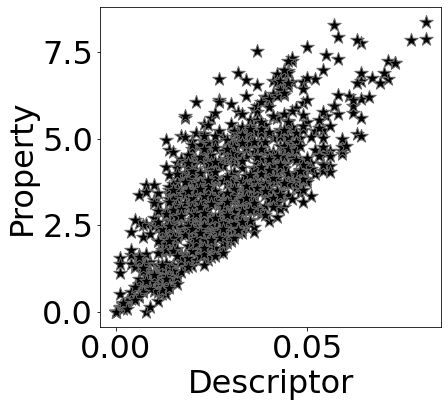

In [64]:
##   Visualize Data   ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

#a = [-175,0,125]
#b = [-175,0,125]
#plt.plot(b, a, c='k', ls='-')

plt.ylabel('Property', fontname='Arial Narrow', size=32)
plt.xlabel('Descriptor', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)
#plt.ylim([-1.0, 9.3])
#plt.xlim([-1.0, 9.3])

yy = [0.0]*n
xx = [0.0]*n

for i in range(0,n):
    yy[i] = np.float(prop[i])
    xx[i] = np.float(X[i,18])

plt.scatter(xx[:], yy[:], c='k', marker='*', s=200, edgecolors='dimgrey', alpha=1.0)



To train the model we will follow a standard protocol and divide the available data into sets for training and sets for validation. We will do this several times with different data selected for training and validation.

Below, the dataset is divided into a training and test set. Applying t = 0.2 creates an 80-20 training-test split; change t for a different split.

In [65]:
##  Train-Test Split  ##

XX = copy.deepcopy(X)
n = dopant.size
m = np.int(X.size/n)

t = 0.20

X_train, X_test, Prop_train, Prop_test, dop_train, dop_test, sc_train, sc_test, ds_train, ds_test = train_test_split(XX, prop, dopant, CdX, doping_site, test_size=t)

n_tr = Prop_train.size
n_te = Prop_test.size


Prop_train_fl = np.zeros(n_tr)
for i in range(0,n_tr):
    Prop_train_fl[i] = copy.deepcopy(float(Prop_train[i]))

Prop_test_fl = np.zeros(n_te)
for i in range(0,n_te):
    Prop_test_fl[i] = copy.deepcopy(float(Prop_test[i]))
    
X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
for i in range(0,n_tr):
    for j in range(0,m):
        X_train_fl[i][j] = np.float(X_train[i][j])

X_test_fl = [[0.0 for a in range(m)] for b in range(n_te)]
for i in range(0,n_te):
    for j in range(0,m):
        X_test_fl[i][j] = np.float(X_test[i][j])


X_out_fl = [[0.0 for a in range(m)] for b in range(n_out)]
for i in range(0,n_out):
    for j in range(0,m):
        X_out_fl[i][j] = np.float(X_out[i][j])
        
X_all_fl = [[0.0 for a in range(m)] for b in range(n_all)]
for i in range(0,n_all):
    for j in range(0,m):
        X_all_fl[i][j] = np.float(X_all[i][j])



We will now start training the model. We will do this at three different levels of increasing sophistication. The first, and simplest, level ML1 is using the default parameters regression model (eg Random Forest). Next level, ML2, will dig into the model and optimize inernal parameters of the model, hyperparameters, to obtain a better model. The last level, ML3, does hyperparameter optimization and cross-validation. The cross-validation is an important step to avoid or minimize overfitting of the model (think of this as fitting a high-order polynomial to a few data points). At the end, we will do a Grid Search, which is a scheme to march through a grid of hyperparameters, to find the best regression model within this set of hyperparameters.


ML1: Define random forest regressor with default parameters which fits a model to the training data and makes predictions on the test dataset. 

Print out the training and test predictions as .csv or .txt files if desired.


{}


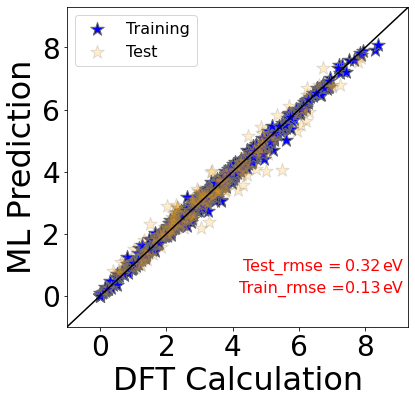

In [67]:
 ###   Random Forest 1st Run: With Default Hyperparameters   ###

param_grid = { }
    
rfreg_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)

rfreg_opt.fit(X_train_fl, Prop_train_fl)
Pred_train_fl = rfreg_opt.predict(X_train_fl)
Pred_test_fl  = rfreg_opt.predict(X_test_fl)

print(rfreg_opt.best_params_)

np.savetxt('Pred_train.csv', Pred_train_fl)
np.savetxt('Pred_test.csv', Pred_test_fl)


##  Prediction RMSE  ##

rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )


##  Plot Regression Results  ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])

te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})


ML2: Perform hyperparameter optimization when training random forest regression model. We define 5 hyperparameters to be tuned: number of estimators (number of trees in the forest), maximum depth of a tree, maximum features considered when looking for the best split, minimum number of samples required at a leaf node, and minimum number of samples required to split an internal node. All or some of these hyperparameters may be optimized by changing the rfregs_all definition loop. The Scikit-learn feature GridSearchCV enables looping through all combinations of hyperparameters and obtained the best set that minimizes test prediction error. 

Print out the training and test predictions as .csv or .txt files if desired. 


In [ ]:
 ###   Random Forest 2nd Run: With Hyperparameter Optimization   ###

param_grid = {
    "n_estimators": [50, 100, 200],
              "max_depth": [5, 10, 15],
              "max_features": [10, 15, m],
              "min_samples_leaf": [5,10,20],
              "min_samples_split": [2, 5, 10]
}
    
rfreg_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)

rfreg_opt.fit(X_train_fl, Prop_train_fl)
Pred_train_fl = rfreg_opt.predict(X_train_fl)
Pred_test_fl  = rfreg_opt.predict(X_test_fl)

print(rfreg_opt.best_params_)

np.savetxt('Pred_train.csv', Pred_train_fl)
np.savetxt('Pred_test.csv', Pred_test_fl)


##  Prediction RMSE  ##

rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )


##  Plot Regression Results  ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])

te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})


{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


ML3: Perform hyperparameter optimization (same as ML2) + cross-validation (used to take care of overfitting in machine learning). Change n-fold to define the type of cross-validation (CV), for eg. 5-fold CV (cv=5). GridSearchCV is used as before but defining cv=n means that at every point, the training data is divided into n folds; (n-1) sets are used at a time to train the model and the n-set (left out) is used for testing. The CV training and CV test errors are defined as averages over the n sets; the set of hyperparameters leading to minimum CV test error is taken as the optimal regressor. 

Print out the training and test predictions as .csv or .txt files if desired.


In [ ]:
 ###   Random Forest 3rd Run: With Hyperparameter Optimization and Cross-Validation   ###

param_grid = {
    "n_estimators": [50, 100, 200],
              "max_depth": [5, 10, 15],
              "max_features": [10, 15, m],
              "min_samples_leaf": [5,10,20],
              "min_samples_split": [2, 5, 10]
}
    
rfreg_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)

rfreg_opt.fit(X_train_fl, Prop_train_fl)
Pred_train_fl = rfreg_opt.predict(X_train_fl)
Pred_test_fl  = rfreg_opt.predict(X_test_fl)

print(rfreg_opt.best_params_)

np.savetxt('Pred_train.csv', Pred_train_fl)
np.savetxt('Pred_test.csv', Pred_test_fl)


##  Prediction RMSE  ##

rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )


##  Plot Regression Results  ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])

te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})


To compare random forest with another ML technique:

Kernel Ridge Regression with hyperparameter optimization and cross-validation using GridSearchCV.


In [ ]:
##  Train Kernel Ridge Regression Model  ##


param_grid = {
"alpha": [1e1, 1e0, 1e-1, 1e-2],
"kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
}

krr_opt = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)

krr_opt.fit(X_train_fl, Prop_train_fl)
Pred_train_fl = krr_opt.predict(X_train_fl)
Pred_test_fl  = krr_opt.predict(X_test_fl)

print(krr_opt.best_params_)

np.savetxt('Pred_train.csv', Pred_train_fl)
np.savetxt('Pred_test.csv', Pred_test_fl)


##  Prediction RMSE  ##

rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )


##  Plot Regression Results  ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])

te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})


To compare random forest with another ML technique:

LASSO Regression with hyperparameter optimization and cross-validation using GridSearchCV.

In [ ]:
##  Train LASSO Regression Model  ##


param_grid = {
"alpha": [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4],
"max_iter": [1e3, 134, 1e5, 1e6, 1e7, 1e8]
}

lassoreg = GridSearchCV(Lasso(), param_grid=param_grid, cv=5)

lassoreg.fit(X_train_fl, Prop_train_fl)
Pred_train_fl = lassoreg.predict(X_train_fl)
Pred_test_fl  = lassoreg.predict(X_test_fl)

print(lassoreg.best_params_)

np.savetxt('Pred_train.csv', Pred_train_fl)
np.savetxt('Pred_test.csv', Pred_test_fl)


##  Prediction RMSE  ##

rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )


##  Plot Regression Results  ##

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])
plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])

te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)

plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3918332544787688, tolerance: 0.15442215950380792
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1754173617403012, tolerance: 0.16178726508033062
  positive)


Use the optimal regressor as obtained above (RF or KRR or LASSO) to make predictions on (a) the outside dataset, which contains additional DFT data generated for CdTeSe and CdSeS compounds (which were not included at all in Data.csv, the file used for training and testing the regression models), and (b) the entire chemical space, which contains all the DFT data points + the missing data points which make up ~ 80% of the total data points. Print out the predictions as .csv or .txt files if desired.

In [ ]:
###    Outside Prediction    ###

reg_opt = rfreg_opt
#reg_opt = krr_opt
#reg_opt = lassoreg


Pred_out = reg_opt.predict(X_out)
Pred_out_fl = [0.0]*Pred_out.size
Prop_out_fl = [0.0]*Pred_out.size
for i in range(0,prop_out.size):
    Prop_out_fl[i] = np.float(prop_out[i])
for i in range(0,prop_out.size):
    Pred_out_fl[i] = np.float(Pred_out[i])

np.savetxt('Pred_out.csv', Pred_out_fl)



Pred_all = reg_opt.predict(X_all)
Pred_all_fl = [0.0]*Pred_all.size
for i in range(0,Pred_all.size):
    Pred_all_fl[i] = np.float(Pred_all[i])

np.savetxt('Pred_all.csv', Pred_all_fl)


If error bars are desired, they can be calculated from the random forest regressor based on the standard deviation of predictions from across the different estimators or trees in the forest. Change the percentile from 95 if needed. Error bars are estimated based on the RF predictors for the training, test, outside and entire datasets.


In [ ]:
##  Error Bars of Training and Test Datasets  ##


percentile = 95


best_params = rfreg_opt.best_params_
    
#rfr = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], max_features=best_params["max_features"], min_samples_leaf=best_params["min_samples_leaf"], min_samples_split=best_params["min_samples_split"])
rfr = RandomForestRegressor(bootstrap=True, criterion='mae')

rfr.fit(X_train_fl, Prop_train_fl)

err_up_train   = [0.0]*n_tr
err_down_train = [0.0]*n_tr
preds_fl = [[0.0 for a in range(n_tr)] for b in range (len(rfr.estimators_))]
z = 0

for pred in rfr.estimators_:
    preds = pred.predict(X_train)
    for i in range(0,n_tr):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfr.estimators_)
for i in range(n_tr):
    for j in range(0,len(rfr.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_train[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_train[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)



err_up_test   = [0.0]*n_te
err_down_test = [0.0]*n_te
preds_fl = [[0.0 for a in range(n_te)] for b in range (len(rfr.estimators_))]
z = 0

for pred in rfr.estimators_:
    preds = pred.predict(X_test)
    for i in range(0,n_te):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfr.estimators_)
for i in range(n_te):
    for j in range(0,len(rfr.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_test[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_test[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


#np.savetxt('up_train.csv', err_up_train)
#np.savetxt('down_train.csv', err_down_train)
#np.savetxt('up_test.csv', err_up_test)
#np.savetxt('down_test.csv', err_down_test)



    

###     Error Bars on Outside Dataset    ###
    
    
    
err_up_out = [0.0]*n_out
err_down_out = [0.0]*n_out
preds_fl = [[0.0 for a in range(n_out)] for b in range (len(rfr.estimators_))]
z = 0

for pred in rfr.estimators_:
    preds = pred.predict(X_out)
    for i in range(0,n_out):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfr.estimators_)
for i in range(n_out):
    for j in range(0,len(rfr.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_out[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_out[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


up_out = [0.0]*n_out
down_out = [0.0]*n_out

for i in range(0,n_out):
    up_out[i] = err_up_out[i] - Pred_out_fl[i]
    down_out[i] = Pred_out_fl[i] - err_down_out[i]


#np.savetxt('up_out.csv', up_out)
#np.savetxt('down_out.csv', down_out)





###     Error Bars for Entire Chemical Space    ###


err_up_all = [0.0]*n_all
err_down_all = [0.0]*n_all
preds_fl = [[0.0 for a in range(n_all)] for b in range (len(rfr.estimators_))]
z = 0

for pred in rfr.estimators_:
    preds = pred.predict(X_all)
    for i in range(0,n_all):
        preds_fl[z][i] = np.float(preds[i])
    z = z+1

pp = [0.0]*len(rfr.estimators_)
for i in range(n_all):
    for j in range(0,len(rfr.estimators_)):
        pp[j] = preds_fl[j][i]
    err_down_all[i] = np.percentile(pp[:], (100 - percentile) / 2. )
    err_up_all[i] = np.percentile(pp[:], 100 - (100 - percentile) / 2.)


up_all = [0.0]*n_all
down_all = [0.0]*n_all

for i in range(0,n_all):
    up_all[i] = err_up_all[i] - Pred_all_fl[i]
    down_all[i] = Pred_all_fl[i] - err_down_all[i]



#np.savetxt('up_all.csv', up_all)
#np.savetxt('down_all.csv', down_all)



*This section is not very important and can be ignored:

Divide actual and predicted data by CdX compound type (CdTe or CdSe or CdS). Every training and test point is designated as belonging to one of these compound types and a different symbol is used for each when plotting the results.


In [ ]:
##  Predicted Data by Type of CdX Compound  ##


Prop_train_CdTe = [0.0]*len(Prop_train_fl)
Prop_train_CdSe = [0.0]*len(Prop_train_fl)
Prop_train_CdS = [0.0]*len(Prop_train_fl)
Prop_test_CdTe = [0.0]*len(Prop_test_fl)
Prop_test_CdSe = [0.0]*len(Prop_test_fl)
Prop_test_CdS = [0.0]*len(Prop_test_fl)

Pred_train_CdTe = [0.0]*len(Pred_train_fl)
Pred_train_CdSe = [0.0]*len(Pred_train_fl)
Pred_train_CdS = [0.0]*len(Pred_train_fl)
Pred_test_CdTe = [0.0]*len(Pred_test_fl)
Pred_test_CdSe = [0.0]*len(Pred_test_fl)
Pred_test_CdS = [0.0]*len(Pred_test_fl)


aa = 0
bb = 0
cc = 0
dd = 0
ee = 0
ff = 0
gg = 0
hh = 0
ii = 0
jj = 0
kk = 0
ll = 0

for i in range(0,Prop_train_fl.size):
    if sc_train[i] == 'CdTe':
        Prop_train_CdTe[aa] = Prop_train_fl[i]
        Pred_train_CdTe[aa] = Pred_train_fl[i]
        aa = aa+1
    if sc_train[i] == 'CdSe':
        Prop_train_CdSe[bb] = Prop_train_fl[i]
        Pred_train_CdSe[bb] = Pred_train_fl[i]
        bb = bb+1
    if sc_train[i] == 'CdS':
        Prop_train_CdS[cc] = Prop_train_fl[i]
        Pred_train_CdS[cc] = Pred_train_fl[i]
        cc = cc+1

for i in range(0,Prop_test_fl.size):
    if sc_test[i] == 'CdTe':
        Prop_test_CdTe[dd] = Prop_test_fl[i]
        Pred_test_CdTe[dd] = Pred_test_fl[i]
        dd = dd+1
    if sc_test[i] == 'CdSe':
        Prop_test_CdSe[ee] = Prop_test_fl[i]
        Pred_test_CdSe[ee] = Pred_test_fl[i]
        ee = ee+1
    if sc_test[i] == 'CdS':
        Prop_test_CdS[ff] = Prop_test_fl[i]
        Pred_test_CdS[ff] = Pred_test_fl[i]
        ff = ff+1


*This section is not very important and can be ignored:

Divide actual and predicted data by CdX compound type (CdTe or CdSe or CdS), including RF predicted error bars. Every training and test point is designated as belonging to one of these compound types and a different symbol is used for each when plotting the results.


In [ ]:
##  Predicted Data by Type of CdX Compound  ##


Prop_train_CdTe = [0.0]*len(Prop_train_fl)
err_up_train_CdTe = copy.deepcopy(err_up_train)
err_down_train_CdTe = copy.deepcopy(err_down_train)

Prop_train_CdSe = [0.0]*len(Prop_train_fl)
err_up_train_CdSe = copy.deepcopy(err_up_train)
err_down_train_CdSe = copy.deepcopy(err_down_train)

Prop_train_CdS = [0.0]*len(Prop_train_fl)
err_up_train_CdS = copy.deepcopy(err_up_train)
err_down_train_CdS = copy.deepcopy(err_down_train)

Prop_test_CdTe = [0.0]*len(Prop_test_fl)
err_up_test_CdTe = copy.deepcopy(err_up_test)
err_down_test_CdTe = copy.deepcopy(err_down_test)

Prop_test_CdSe = [0.0]*len(Prop_test_fl)
err_up_test_CdSe = copy.deepcopy(err_up_test)
err_down_test_CdSe = copy.deepcopy(err_down_test)

Prop_test_CdS = [0.0]*len(Prop_test_fl)
err_up_test_CdS = copy.deepcopy(err_up_test)
err_down_test_CdS = copy.deepcopy(err_down_test)


Pred_train_CdTe = [0.0]*len(Pred_train_fl)
Pred_train_CdSe = [0.0]*len(Pred_train_fl)
Pred_train_CdS = [0.0]*len(Pred_train_fl)
Pred_test_CdTe = [0.0]*len(Pred_test_fl)
Pred_test_CdSe = [0.0]*len(Pred_test_fl)
Pred_test_CdS = [0.0]*len(Pred_test_fl)



aa = 0
bb = 0
cc = 0
dd = 0
ee = 0
ff = 0
gg = 0
hh = 0
ii = 0
jj = 0
kk = 0
ll = 0

for i in range(0,Prop_train_fl.size):
    if sc_train[i] == 'CdTe':
        Prop_train_CdTe[aa] = Prop_train_fl[i]
        Pred_train_CdTe[aa] = Pred_train_fl[i]
        err_up_train_CdTe[aa] = err_up_train[i]
        err_down_train_CdTe[aa] = err_down_train[i]
        aa = aa+1
    if sc_train[i] == 'CdSe':
        Prop_train_CdSe[bb] = Prop_train_fl[i]
        Pred_train_CdSe[bb] = Pred_train_fl[i]
        err_up_train_CdSe[bb] = err_up_train[i]
        err_down_train_CdSe[bb] = err_down_train[i]
        bb = bb+1
    if sc_train[i] == 'CdS':
        Prop_train_CdS[cc] = Prop_train_fl[i]
        Pred_train_CdS[cc] = Pred_train_fl[i]
        err_up_train_CdS[cc] = err_up_train[i]
        err_down_train_CdS[cc] = err_down_train[i]
        cc = cc+1

for i in range(0,Prop_test_fl.size):
    if sc_test[i] == 'CdTe':
        Prop_test_CdTe[dd] = Prop_test_fl[i]
        Pred_test_CdTe[dd] = Pred_test_fl[i]
        err_up_test_CdTe[dd] = err_up_test[i]
        err_down_test_CdTe[dd] = err_down_test[i]
        dd = dd+1
    if sc_test[i] == 'CdSe':
        Prop_test_CdSe[ee] = Prop_test_fl[i]
        Pred_test_CdSe[ee] = Pred_test_fl[i]
        err_up_test_CdSe[ee] = err_up_test[i]
        err_down_test_CdSe[ee] = err_down_test[i]
        ee = ee+1
    if sc_test[i] == 'CdS':
        Prop_test_CdS[ff] = Prop_test_fl[i]
        Pred_test_CdS[ff] = Pred_test_fl[i]
        err_up_test_CdS[ff] = err_up_test[i]
        err_down_test_CdS[ff] = err_down_test[i]
        ff = ff+1



up_train_CdTe = [0.0]*aa
down_train_CdTe = [0.0]*aa
up_test_CdTe = [0.0]*dd
down_test_CdTe = [0.0]*dd

up_train_CdSe = [0.0]*bb
down_train_CdSe = [0.0]*bb
up_test_CdSe = [0.0]*ee
down_test_CdSe = [0.0]*ee

up_train_CdS = [0.0]*cc
down_train_CdS = [0.0]*cc
up_test_CdS = [0.0]*ff
down_test_CdS = [0.0]*ff


for i in range(0,aa):
    up_train_CdTe[i]   = err_up_train_CdTe[i] - Pred_train_CdTe[i]
    down_train_CdTe[i] = Pred_train_CdTe[i] - err_down_train_CdTe[i]
for i in range(0,bb):
    up_train_CdSe[i] = err_up_train_CdSe[i] - Pred_train_CdSe[i]
    down_train_CdSe[i] = Pred_train_CdSe[i] - err_down_train_CdSe[i]
for i in range(0,cc):
    up_train_CdS[i] = err_up_train_CdS[i] - Pred_train_CdS[i]
    down_train_CdS[i] = Pred_train_CdS[i] - err_down_train_CdS[i]



for i in range(0,dd):
    up_test_CdTe[i] = err_up_test_CdTe[i] - Pred_test_CdTe[i]
    down_test_CdTe[i] = Pred_test_CdTe[i] - err_down_test_CdTe[i]
for i in range(0,ee):
    up_test_CdSe[i] = err_up_test_CdSe[i] - Pred_test_CdSe[i]
    down_test_CdSe[i] = Pred_test_CdSe[i] - err_down_test_CdSe[i]
for i in range(0,ff):
    up_test_CdS[i] = err_up_test_CdS[i] - Pred_test_CdS[i]
    down_test_CdS[i] = Pred_test_CdS[i] - err_down_test_CdS[i]



Print out prediction root mean square errors for training, test and outside points, by semiconductor type.

In [ ]:




##  Calculate Prediction RMSE  ##


rmse_test_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_fl, Pred_test_fl) )
rmse_train_prop = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_fl, Pred_train_fl) )
print('rmse_test_prop=', rmse_test_prop)
print('rmse_train_prop=', rmse_train_prop)

rmse_test_CdTe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdTe[0:dd], Pred_test_CdTe[0:dd]) )
rmse_train_CdTe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdTe[0:aa], Pred_train_CdTe[0:aa]) )
print('rmse_test_CdTe=', rmse_test_CdTe)
print('rmse_train_CdTe=', rmse_train_CdTe)

rmse_test_CdSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdSe[0:ee], Pred_test_CdSe[0:ee]) )
rmse_train_CdSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdSe[0:bb], Pred_train_CdSe[0:bb]) )
print('rmse_test_CdSe=', rmse_test_CdSe)
print('rmse_train_CdSe=', rmse_train_CdSe)

rmse_test_CdS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_test_CdS[0:ff], Pred_test_CdS[0:ff]) )
rmse_train_CdS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_train_CdS[0:cc], Pred_train_CdS[0:cc]) )
print('rmse_test_CdS=', rmse_test_CdS)
print('rmse_train_CdS=', rmse_train_CdS)

rmse_CdTeSe = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[0:22], Pred_out_fl[0:22]) )
rmse_CdSeS = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[22:44], Pred_out_fl[22:44]) )
print('rmse_CdTeSe=', rmse_CdTeSe)
print('rmse_CdSeS=', rmse_CdSeS)
rmse_out = np.sqrt ( sklearn.metrics.mean_squared_error(Prop_out_fl[0:44], Pred_out_fl[0:44]) )











rmse_test_prop= 0.34431477842437536
rmse_train_prop= 0.2674873651901901
rmse_test_CdTe= 0.26536209070826033
rmse_train_CdTe= 0.22184903769999237
rmse_test_CdSe= 0.3580096688935943
rmse_train_CdSe= 0.2738490922760957
rmse_test_CdS= 0.391944793185341
rmse_train_CdS= 0.30148819952848444
rmse_CdTeSe= 0.4742151156291638
rmse_CdSeS= 0.5571497503713383


Plot regression results as DFT vs ML parity plots; comment out error bars if not desired.

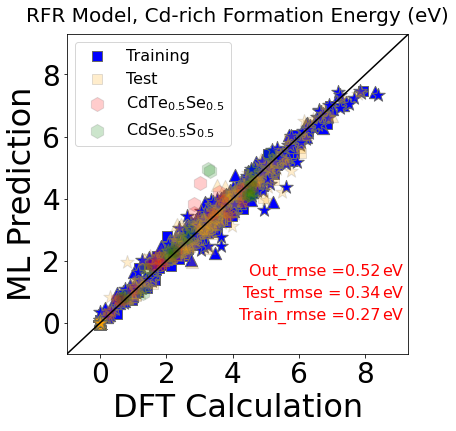

In [ ]:




##  Plot Regression Results  ##


plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.16, bottom=0.16, right=0.95, top=0.90)
plt.rc('font', family='Arial narrow')

plt.title('RFR Model, Cd-rich Formation Energy (eV)', fontsize=20, pad=12)
#plt.title('KRR Model, Cd-rich Formation Energy (eV)', fontsize=20, pad=12)

a = [-175,0,125]
b = [-175,0,125]
plt.plot(b, a, c='k', ls='-')

plt.ylabel('ML Prediction', fontname='Arial Narrow', size=32)
plt.xlabel('DFT Calculation', fontname='Arial Narrow', size=32)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.ylim([-1.0, 9.3])
plt.xlim([-1.0, 9.3])

#plt.scatter(Prop_train_fl[:], Pred_train_fl[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='Training')
#plt.scatter(Prop_test_fl[:], Pred_test_fl[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='Test')


plt.scatter(Prop_train_CdTe[:], Pred_train_CdTe[:], c='blue', marker='s', s=100, edgecolors='dimgrey', alpha=1.0, label='Training')
plt.scatter(Prop_train_CdSe[:], Pred_train_CdSe[:], c='blue',marker='^', s=150, edgecolors='dimgrey', alpha=1.0, label='_nolegend_')
plt.scatter(Prop_train_CdS[:], Pred_train_CdS[:], c='blue', marker='*', s=200, edgecolors='dimgrey', alpha=1.0, label='_nolegend_')
plt.scatter(Prop_test_CdTe[:], Pred_test_CdTe[:], c='orange', marker='s', s=100, edgecolors='dimgrey', alpha=0.2, label='Test')
plt.scatter(Prop_test_CdSe[:], Pred_test_CdSe[:], c='orange', marker='^', s=150, edgecolors='dimgrey', alpha=0.2, label='_nolegend_')
plt.scatter(Prop_test_CdS[:], Pred_test_CdS[:], c='orange', marker='*', s=200, edgecolors='dimgrey', alpha=0.2, label='_nolegend_')
plt.scatter(Prop_out_fl[0:22], Pred_out_fl[0:22], c='red', marker='h', s=200, edgecolors='dimgrey', alpha=0.2, label='CdTe$_{0.5}$Se$_{0.5}$')
plt.scatter(Prop_out_fl[22:44], Pred_out_fl[22:44], c='green', marker='h', s=200, edgecolors='dimgrey', alpha=0.2, label='CdSe$_{0.5}$S$_{0.5}$')


# plt.errorbar(Prop_train_CdTe[0:aa], Pred_train_CdTe[0:aa], yerr = [up_train_CdTe[0:aa], down_train_CdTe[0:aa]], c='blue', marker='s', alpha=1.0, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='blue', capthick=1, label='Training')
# plt.errorbar(Prop_train_CdSe[0:bb], Pred_train_CdSe[0:bb], yerr = [up_train_CdSe[0:bb], down_train_CdSe[0:bb]], c='blue', marker='^', alpha=1.0, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='blue', capthick=1, label='_nolegend_')
# plt.errorbar(Prop_train_CdS[0:cc], Pred_train_CdS[0:cc], yerr = [up_train_CdS[0:cc], down_train_CdS[0:cc]], c='blue', marker='*', alpha=1.0, markeredgecolor='dimgrey', markersize=12, fmt='o', ecolor='blue', capthick=1, label='_nolegend_')

# plt.errorbar(Prop_test_CdTe[0:dd], Pred_test_CdTe[0:dd], yerr = [up_test_CdTe[0:dd], down_test_CdTe[0:dd]], c='orange', marker='s', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='orange', capthick=1, label='Test')
# plt.errorbar(Prop_test_CdSe[0:ee], Pred_test_CdSe[0:ee], yerr = [up_test_CdSe[0:ee], down_test_CdSe[0:ee]], c='orange', marker='^', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='orange', capthick=1, label='_nolegend_')
# plt.errorbar(Prop_test_CdS[0:ff], Pred_test_CdS[0:ff], yerr = [up_test_CdS[0:ff], down_test_CdS[0:ff]], c='orange', marker='*', alpha=0.2, markeredgecolor='dimgrey', markersize=12, fmt='o', ecolor='orange', capthick=1, label='_nolegend_')

# plt.errorbar(Prop_out_fl[0:22], Pred_out_fl[0:22], yerr = [up_out[0:22], down_out[0:22]], c='red', marker='h', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='red', capthick=1, label='CdTe$_{0.5}$Se$_{0.5}$')
# plt.errorbar(Prop_out_fl[22:44], Pred_out_fl[22:44], yerr = [up_out[22:44], down_out[22:44]], c='green', marker='h', alpha=0.2, markeredgecolor='dimgrey', markersize=8, fmt='o', ecolor='green', capthick=1, label='CdSe$_{0.5}$S$_{0.5}$')


te = '%.2f' % rmse_test_prop
tr = '%.2f' % rmse_train_prop
out = '%.2f' % rmse_out

plt.text(4.5, 1.5, 'Out_rmse = ', c='r', fontsize=16)
plt.text(7.4, 1.5, out, c='r', fontsize=16)
plt.text(8.5, 1.5, 'eV', c='r', fontsize=16)
plt.text(4.3, 0.8, 'Test_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.8, te, c='r', fontsize=16)
plt.text(8.5, 0.8, 'eV', c='r', fontsize=16)
plt.text(4.2, 0.1, 'Train_rmse = ', c='r', fontsize=16)
plt.text(7.4, 0.1, tr, c='r', fontsize=16)
plt.text(8.5, 0.1, 'eV', c='r', fontsize=16)


plt.xticks([0, 2, 4, 6, 8])
plt.yticks([0, 2, 4, 6, 8])
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':16})
plt.savefig('plot_Cd_rich.pdf', dpi=450)
